In [10]:
import torch
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms

import os 
import numpy as np
import matplotlib.pyplot as plt

from model import Classifier
from dataset import FramesDataset
from utils import save
from train import train
from eval import eval

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [12]:
# Define transforms for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

dataset = FramesDataset('note_frames_multi/', 91, transforms=transform)
# train_loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2)

train_size = int(0.8 * len(dataset))
test_size = int(0.1 * len(dataset))
val_size = len(dataset) - train_size - test_size
train_dataset, test_dataset, val_dataset = random_split(dataset, [train_size, test_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

In [13]:
models_dict = {
    'simpleCNN': 'simple',
    'ResNet18': 'resnet18',
    'ResNet50': 'resnet50',
    'ViT16': 'vit16',
    'ViT32': 'vit32'
}

In [ ]:
# Train models non pretrained
for key in models_dict.keys():
    # Create an instance of the model
    model = Classifier(encoder=models_dict[key]).to(device)
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    best_model, train_loss, test_loss, accuracy = train(model, criterion, optimizer, 100, train_loader, test_loader, device)
    save(key, best_model, train_loss, test_loss, accuracy)

# Evaluate

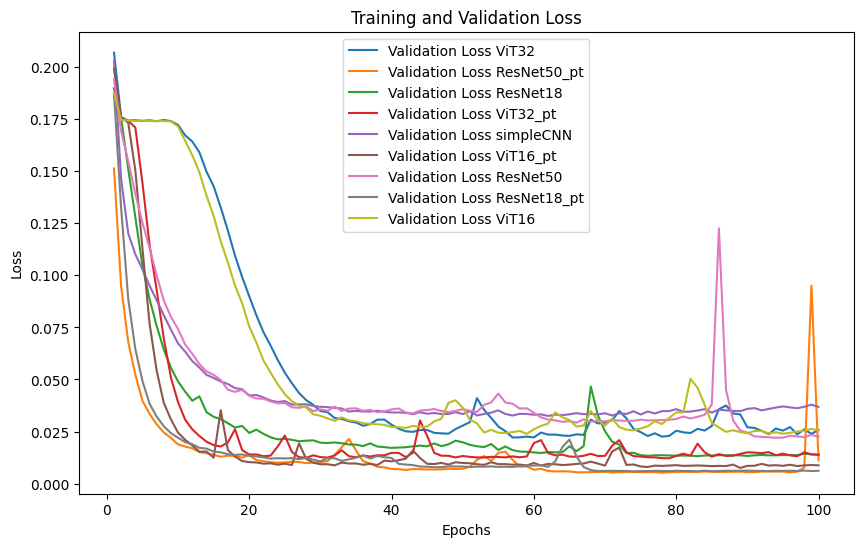

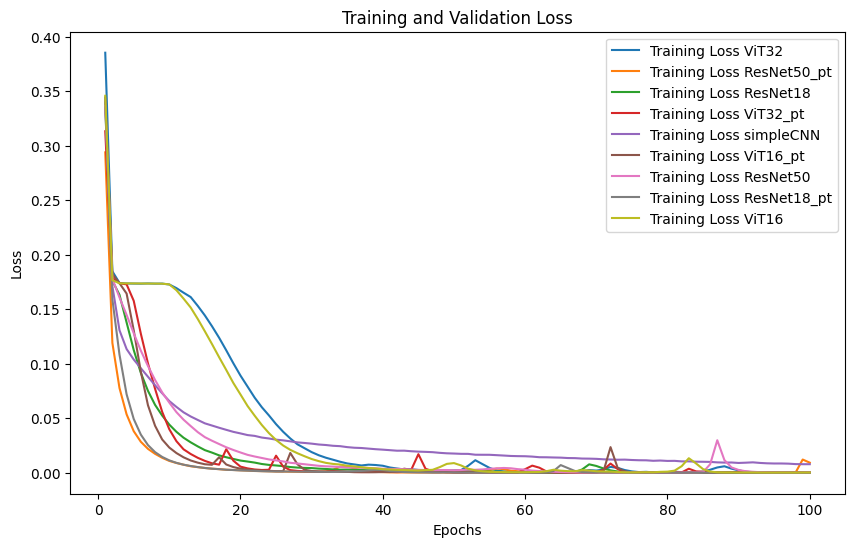

In [14]:
plt.figure(figsize=(10, 6))
for result in os.listdir(os.path.join('results')):
    accuracy = np.load(os.path.join('results', result, 'accuracy.npy'))
    test_loss = np.load(os.path.join('results', result, 'test_loss.npy'))
    epochs = epochs = range(1, accuracy.shape[0] + 1)
    plt.plot(epochs, test_loss[:], label=f'Validation Loss {result}')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for result in os.listdir(os.path.join('results')):
    accuracy = np.load(os.path.join('results', result, 'accuracy.npy'))
    train_loss = np.load(os.path.join('results', result, 'train_loss.npy'))
    epochs = epochs = range(1, accuracy.shape[0] + 1)
    plt.plot(epochs, train_loss[:], label=f'Training Loss {result}')
    # break

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.show()

In [15]:
conf_all = []
for model_name in os.listdir(os.path.join('results')):
    if 'simple' in model_name.lower():
        continue
    if 'vit' in model_name.lower():
        continue
    model_path = os.path.join('results', model_name, 'model.pt')
    pretrained = '_' in model_name
    
    model = Classifier(encoder=model_name.split('_')[0].lower(), pretrained=pretrained)
    model.load_state_dict(torch.load(os.path.join('results', model_name, 'model.pt')))
    model.to(device)

    conf = eval(model, val_loader, device)
    conf_all.append([model_name, conf])


In [16]:
for model_name in os.listdir(os.path.join('results')):
    if 'vit' in model_name.lower():
        
        model_path = os.path.join('results', model_name, 'model.pt')
        pretrained = '_' in model_name
        
        model = Classifier(encoder=model_name.split('_')[0].lower(), pretrained=pretrained)
        model.load_state_dict(torch.load(os.path.join('results', model_name, 'model.pt')))
        model.to(device)

        conf = eval(model, val_loader, device)
        conf_all.append([model_name, conf])


In [18]:
model = Classifier(encoder='simple', pretrained=pretrained)
model.load_state_dict(torch.load(os.path.join('results', 'simpleCNN', 'model.pt')))
model.to(device)

conf = eval(model, val_loader, device)
conf_all.append(['simple', conf])

In [19]:
for i in range(len(conf_all)):
    print(conf_all[i][0], conf_all[i][1].compute())

ResNet50_pt tensor([[50817,    30],
        [  143,  2020]])
ResNet18 tensor([[50840,     7],
        [  147,  2016]])
ResNet50 tensor([[50825,    22],
        [  232,  1931]])
ResNet18_pt tensor([[50844,     3],
        [   62,  2101]])
ViT32 tensor([[50831,    16],
        [  178,  1985]])
ViT32_pt tensor([[50829,    18],
        [   91,  2072]])
ViT16_pt tensor([[50841,     6],
        [   69,  2094]])
ViT16 tensor([[50798,    49],
        [  170,  1993]])
simple tensor([[50734,   113],
        [  241,  1922]])
